In [1]:
import os
import sys
sys.path.append(os.path.abspath("../../src/"))
sys.path.append(os.path.abspath("/home/muzakka/Development/LHAPDF/"))
from tools import PDFs
import matplotlib.pyplot as plt
import numpy as np
import lhapdf
import scipy.integrate as integrate
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import scipy.optimize
import math
from scipy.interpolate import Rbf
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import scipy
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)

In [2]:
a = np.loadtxt("p40/chi2.dat")
#chi2min = a[0]
#a= np.delete(a, 0)
print(np.average(a), np.std(a))
#print(chi2min, np.average(a))


5326.895697211155 154.60793311561613


In [6]:
a = np.loadtxt("p25/chi2.dat")
#chi2min = a[0]
a= np.delete(a, 0)
print(np.average(a), np.std(a))
#print(chi2min, np.average(a))


5332.662952646239 156.34740110570274


In [7]:
cov = np.loadtxt("p40/min.dat")
#cov_0= cov[0,:]
#cov = np.delete(cov, 0, axis=0)
ave = np.average(cov, axis=0)
print(ave)
cov = np.cov(cov, rowvar=False)
hess = np.linalg.inv(cov)
np.savetxt("min_replica_p40.txt", ave)
np.savetxt("hessian_replica_p40.txt", hess)

[-2.08770880e+00  7.59294701e-01 -2.04473769e-01  7.99936080e+00
 -3.64094622e-03 -7.19034088e-02 -4.24701701e-01 -7.70044988e-02
 -1.21734665e-01 -1.21575406e+00 -3.81493829e+00  1.95803753e+00
  1.61340721e+00 -4.66445920e-02  7.36238884e-03  3.43355944e-01
  5.06184422e-01  2.84285550e+00 -1.37881651e-02  5.04770853e-01
  6.40056418e-02  3.39357068e-02 -1.37164633e+00  2.06848594e+01
  5.06459936e-01  3.16649028e-01  2.23983343e+00  4.28508382e-02
  2.74578546e-01  5.00561088e-01 -2.76722924e-01 -1.25132680e-04
  6.79874948e+00  2.15517665e-01  4.79196624e-03 -1.31740649e-02
 -1.38591016e+00  1.05478790e-01  3.23174649e-01 -3.85676693e-01]


LHAPDF 6.5.1 loading all 252 PDFs in set Base_nCTEQ22_MC_208_82
Base_nCTEQ22_MC_208_82, version 1; 252 PDF members
LHAPDF 6.5.1 loading all 361 PDFs in set Base_nCTEQ22_MC_p25_208_82
Base_nCTEQ22_MC_p25_208_82, version 1; 361 PDF members
LHAPDF 6.5.1 loading all 1 PDFs in set Base_nCTEQ22_TMC_HT_CTEQ_i2_208_82
Base_nCTEQ22_TMC_HT_CTEQ_i2_208_82, version 1; 1 PDF members
LHAPDF 6.5.1 loading all 201 PDFs in set nNNPDF30_nlo_as_0118_A208_Z82
nNNPDF30_nlo_as_0118_A208_Z82, version 1; 201 PDF members
LHAPDF 6.5.1 loading all 39 PDFs in set nCTEQ15WZSIH_208_82
nCTEQ15WZSIH_208_82, version 1; 39 PDF members


posx and posy should be finite values


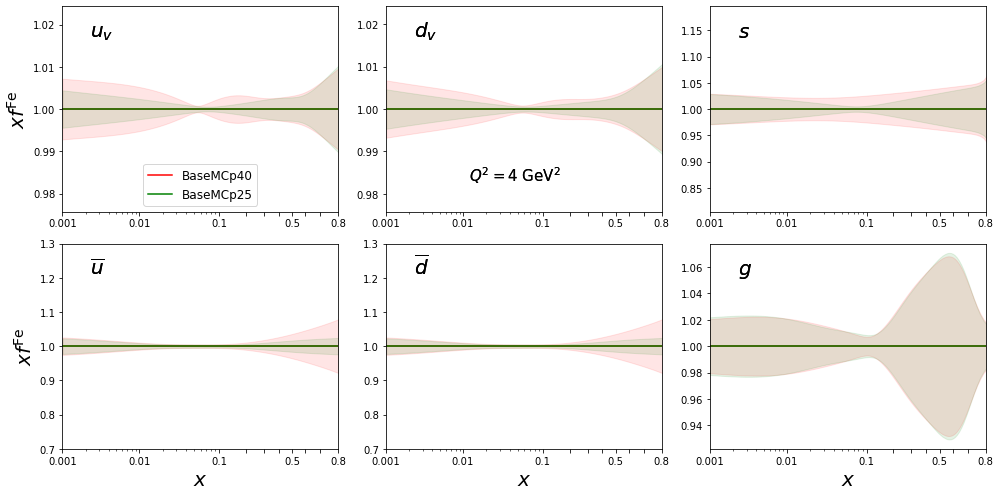

In [9]:
A=208
Z=82
base_MC_p40 = PDFs("Base_nCTEQ22_MC_"+str(A)+"_"+str(Z), "MCreplica", A, Z, True)
base_MC_p25 = PDFs("Base_nCTEQ22_MC_p25_"+str(A)+"_"+str(Z), "MCreplica", A, Z, True)
#base_MChess = PDFs("Base_nCTEQ22_MC_hess_"+str(A)+"_"+str(Z), "sym", A, Z, True)
base_cteq = PDFs("Base_nCTEQ22_TMC_HT_CTEQ_i2_"+str(A)+"_"+str(Z), "sym", A, Z, True)
nnpdf = PDFs("nNNPDF30_nlo_as_0118_A208_Z82", "MCreplica", A, Z, False)
sih = PDFs("nCTEQ15WZSIH_"+str(A)+"_"+str(Z), "sym", A, Z, True)


mypdfs = [ [base_MC_p40, "red", "-", "BaseMCp40", True, 0.1], #pdf, color, linestyle, label, fullnuc, error, allpha
            [base_MC_p25, "green", "-", "BaseMCp25", True, 0.1], #pdf, color, linestyle, label, fullnuc, error, allpha
           #[base_MChess, "green", "dashed", "BaseMChess",  True, 0.1], 
           # [base_cteq, "green", "dashed", "BaseCTEQ",  True, 0.2], 
           #[sih, "red", "-", "SIH",  True, 0.2],           
            # [nnpdf, "cyan", "-", "NNPDF",  True, 0.2]
]

flavors = ["uv", "dv", "s", "ubar", "dbar", "g"]
Q = 2.0
#xlist = np.linspace(0.001, 1.0,500)
xlist = np.logspace(-3,np.log10(0.95),300)
plt.figure(1,figsize=(14,7))
for iflv, flv in enumerate(flavors) :
    ax=plt.subplot2grid((2,3),(int(iflv/3), iflv%3))   
    plt.tight_layout()
    #plt.axhline(1.0, linestyle="dotted")
    #plt.axhline(0.0, linestyle="dotted")
    for i, pdf in enumerate(mypdfs) : 
        data, dp, dm = pdf[0].getPDFerrors(xlist, Q, flv)
        #print(dp, dm)
        #if (i==1) : 
        #    dp = np.sqrt(1/1.645)*dp 
        #    dm = np.sqrt(1/1.645)*dm
        data_cteq =data#, dpd, dmd = base.getPDFerrors(xlist, Q, flv)
        plt.plot(xlist, (data/data_cteq), color=pdf[1], linestyle=pdf[2], label = pdf[3])

        if (pdf[4]) : 
            plt.fill_between(xlist, ((data+dp)/data_cteq), ((data-dp)/data_cteq), color=pdf[1], alpha=pdf[5])

        flvlabel = "$"+flv+"$"
        if (flv == "uv") : 
            flvlabel = "$u_v$"
        elif (flv =="dv") : 
            flvlabel= "$d_v$"
        elif flv=="ubar" : 
            flvlabel = r"$\overline{u}$"
        elif flv=="dbar" : 
            flvlabel = r"$\overline{d}$"


        plt.xscale("logit" ,one_half="0.5")
        if int(iflv/3)==1 : 
            plt.xlabel(r'${x}$',fontsize=20)
        if (iflv%3 ==0) : 
            plt.ylabel(r'${xf^{{\mathrm{{Fe}}}}}$',fontsize=20, rotation=90)
        plt.annotate(flvlabel, xy=(0.1, 0.85), xycoords='axes fraction', fontsize=20)

        
        
        if (flv!="s") : 
            pass#plt.ylim(0.6, 1.4)
        else : 
            pass#plt.ylim(0., 2.4)

        if (iflv==0):
            plt.legend(loc="lower center", fontsize=12)
        if (iflv == 1) : 
            plt.annotate("$Q^2={}\ \mathrm{{GeV}}^2$".format(4), xy=(0.3, 0.15), xycoords='axes fraction', fontsize=15)
        #ax.set_xticklabels(["0","0.001", "0.01", "0.1","0.5","0.9", "0.95"])
        #plt.gca().set_ylim(bottom=0)
        ax.set_xticks([0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
        ax.set_xticklabels(["0.001", "0.01", "0.1","", "", "", "0.5","", "", "0.8","0.9", "0.95"])
        ax.xaxis.set_minor_formatter(NullFormatter())
        plt.xlim(0.001, 0.8)
        
plt.savefig("MChess.pdf", bbox_inches="tight")

In [ ]:

jllllllllllllllllllllllllllll#ll+jll